In [1]:
import pickle
import gzip
import math
import os
import time
import shutil
import torch
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial

In [12]:
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder

In [4]:
from fastprogress import progress_bar, master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

#### Data: fashion Mnist

In [7]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

In [10]:
bs = 256
tds = dsd.with_transform(transformi)

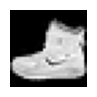

In [15]:
ds = tds['train']
img = ds[0][x]
show_image(img, figsize=(1,1));

In [16]:
cf = collate_dict(ds)

In [17]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [22]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [23]:
dls

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f0a7fd3f970>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f0a7fd3d7b0>}

In [24]:
dt = dls['train']
dv = dls['test']

xb, yb = next(iter(dt))

In [27]:
labels = ds.features[y].names

In [28]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [31]:
lbl_getter

operator.itemgetter(tensor(9, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(7, device='cuda:0'), tensor(2, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(0, device='cuda:0'), tensor(9, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(7, device='cuda:0'), tensor(9, device='cuda:0'))

In [29]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)

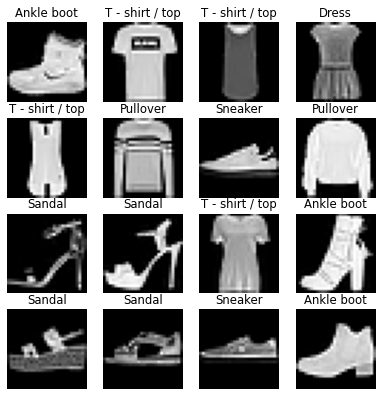

In [30]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

In [32]:
from torch import optim

bs = 256
lr = 0.4

In [33]:
cnn = nn.Sequential(
    conv(1,4),
    conv(4,8),
    conv(8,16),
    conv(16,16),
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [34]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss, acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.7862950892925262 0.7245
1 0.5681402753353119 0.7971
2 0.5660486021995544 0.8057
3 0.5523438681125641 0.8086
4 0.47533732481002805 0.8317


Pb: the training is slow. To accelerate the process one can use multiple CPUs and GPUs if there are. Passing a num_workers >1 in DataLoader should do so. But another problem arises: in python and pytorch, separate processes cannot send elements to the GPU, so one cannot use the collate function as implemented that sends directly to the GPU in a separate process.<br>
. One way is to re-write the fit function <br>
. Another problem is the low accuracy <br>

Let's first look at CNN autoencoders and see how slow the iterations are, we'll address these questions in the next notebook.

#### Autoencoders

In [35]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [36]:
fit??

In [38]:
def eval_(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss, count = 0. ,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred, xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [39]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval_(model, loss_func, valid_dl, epoch)

In [46]:
ae = nn.Sequential(
    nn.ZeroPad2d(2),
    conv(1,2),
    conv(2,4),
    conv(4,8),
    deconv(8,4),
    deconv(4,2),
    deconv(2,1, act=False),
    nn.ZeroPad2d(-2),
    nn.Sigmoid()
).to(def_device)

In [47]:
ae

Sequential(
  (0): ZeroPad2d((2, 2, 2, 2))
  (1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (1): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
  )
  (5): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (1): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
  )
  (6): Sequential(
    (0): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
    (1): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (7): ZeroPad2d((-2, -2, -2, -2))
  (8): Sigmoid()
)

In [48]:
eval_(ae, F.mse_loss, dv)

0 0.149


In [49]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.binary_cross_entropy, opt, dt, dv)

0 0.610
1 0.596
2 0.559
3 0.450
4 0.404


In [53]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.binary_cross_entropy, opt, dt, dv)

0 0.322
1 0.319
2 0.320
3 0.317
4 0.318


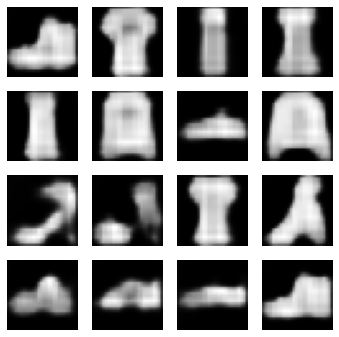

In [54]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

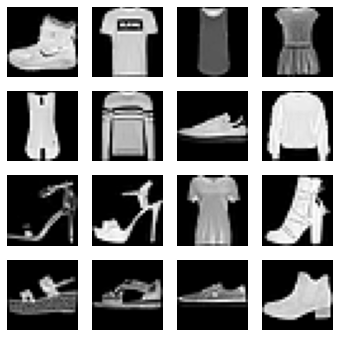

In [52]:
show_images(xb[:16].data.cpu(), imsize=1.5)

The training takes a very long time and does not give a great reconstitution of the images.